# Monte Carlo Simulation - Probit Model 
## Fabrizio Leone
## 06 - 02 - 2019

In [1]:
# Import Packages

#import Pkg; Pkg.add("Distributions")
#import Pkg; Pkg.add("LinearAlgebra")
#import Pkg; Pkg.add("Optim")
#import Pkg; Pkg.add("NLSolversBase")
#import Pkg; Pkg.add("Random")
#import Pkg; Pkg.add("Plots")
#import Pkg; Pkg.add("Statistics")

cd("$(homedir())/Documents/GitHub/Econometrics")

using Distributions, LinearAlgebra, Optim, NLSolversBase, Random, Plots, Statistics
Random.seed!(10);

In [2]:
# Define Parameters

N   = 1000;
b   = [0.2, -0.1];
rep = 1000;


In [3]:
# Define probit objective function

function probit_obj(b::Array{Float64,1},y::Array{Int64,2},X::Array{Float64,2},N::Int64)
    d    = Normal()
    pcdf = cdf.(d, X*b)
    ppdf = pdf.(d, X*b)
    l    = y.*log.(pcdf) + (ones(N,1)-y).*log.(ones(N,1)-pcdf)    # Likelihood
    s    = ppdf.*X.*(y-pcdf)./(pcdf.*(ones(N,1)-pcdf))            # Gradient
    nll  = -mean(l)
    ns   = -sum!([1. 1.], s)/N
    return nll, ns
end

probit_obj (generic function with 1 method)

In [5]:
# Run Monte Carlo Simulation

beta_hat = zeros(N,2)

@time begin
    
for i = 1:rep

# 1. Simulate Data
c    = ones(N,1);
X    = hcat(c, rand(Chisq(10),N,1));
ϵ    = rand(Normal(0,1),N,1);
y    = Int.(X*b.>ϵ);
         
# 2. Run optimization     
function objfun(x)
        probit_obj([x[1],x[2]],y,X,N)[1]
end
        
function gradfun!(G,x)
        grad = probit_obj([x[1],x[2]],y,X,N)[2]
        G[1] = grad[1]
        G[2] = grad[2]
end
                
res  = Optim.optimize(objfun, gradfun!,[0.0, 0.0])
beta_hat[i,:]  = res.minimizer
    
end

end

  5.930761 seconds (2.98 M allocations: 6.374 GiB, 10.56% gc time)


Mean Estimates [0.198049 -0.100288]
SE Estimates [0.00365894 0.000382307]


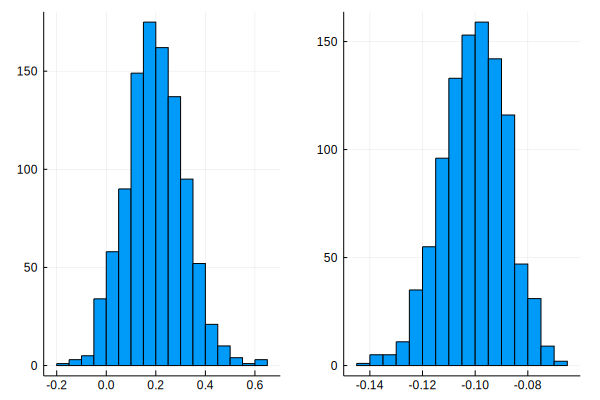

In [6]:
# Show and Plot results

println("Mean Estimates ",sum!([1. 1.], beta_hat)/rep)
println("SE Estimates ", std(beta_hat; mean=nothing, dims=1)/sqrt(N))
h1 = histogram(beta_hat[:,1])
h2 = histogram(beta_hat[:,2])
plot(h1,h2,layout=(1,2),legend=false)
